In [1]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error

In [2]:
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive

In [3]:
import seaborn as sns  # for coloring 

# set style of graphs
plt.style.use('seaborn')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [4]:
df = pd.read_csv('../../stock/AAPL.csv', parse_dates=True, index_col='Date')
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=False)

In [5]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [6]:
target= "Close"
features = ['High', 'Low', 'Open', 'Volume']

In [7]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [8]:
def initTrainDt(stock):
    val_df = SequenceDataset(stock,
                        isval=False)

    val = DataLoader(  # An. off-the-shelf class
            val_df,
            batch_size=24,  # batching is done automatically
            num_workers=4,
        )

    return val

In [9]:
i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.0530, -1.0500, -1.0551,  0.6089],
        [-1.0523, -1.0457, -1.0506, -0.4948],
        [-1.0511, -1.0463, -1.0490, -0.1061],
        [-1.0484, -1.0411, -1.0445, -0.7085]])


In [10]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 4])
tensor([[[ 2.0554,  2.0308,  2.0173, -0.0407],
         [ 2.0726,  2.1026,  2.0785, -0.1875],
         [ 2.1352,  2.1198,  2.0851, -0.0697],
         [ 2.1896,  2.1386,  2.2153,  0.6180]],

        [[ 1.5233,  1.5542,  1.5285, -1.0903],
         [ 1.5996,  1.5911,  1.5519, -0.5532],
         [ 1.6794,  1.6370,  1.6116,  0.3379],
         [ 1.7305,  1.7147,  1.6983, -0.0351]],

        [[-0.7445, -0.7390, -0.7344, -0.4781],
         [-0.7401, -0.7309, -0.7374, -0.8979],
         [-0.7450, -0.7353, -0.7409, -0.5304],
         [-0.7491, -0.7358, -0.7402, -0.8085]]])


In [11]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 30, 4])
Target shape: torch.Size([4])


In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.2):
        super().__init__()
        self.input_dim = input_dim  # this is the number of features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        x = self.dropout(x)
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [13]:
model = LSTM(input_dim=4, hidden_dim=32, num_layers=2, output_dim=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

'''
def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
'''

num_epochs = 10
for t in range(num_epochs):
    train_model(train_loader, model, loss_function, optimizer=optimizer)

Train loss: 0.02075687197029332
Train loss: 0.0021430952522981292
Train loss: 0.0021865527039215934
Train loss: 0.0011326980356735866
Train loss: 0.0028579741560969566
Train loss: 0.001225141787142006
Train loss: 0.0011898944308302902
Train loss: 0.0019976433592779315
Train loss: 0.0011160545153372716
Train loss: 0.0014156225034650475


In [15]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


y_pred = predict(test_loader, model)
y_pred = y_pred * target_stdev + target_mean

In [16]:
y_test = (df_test['Close'] * target_stdev + target_mean).values

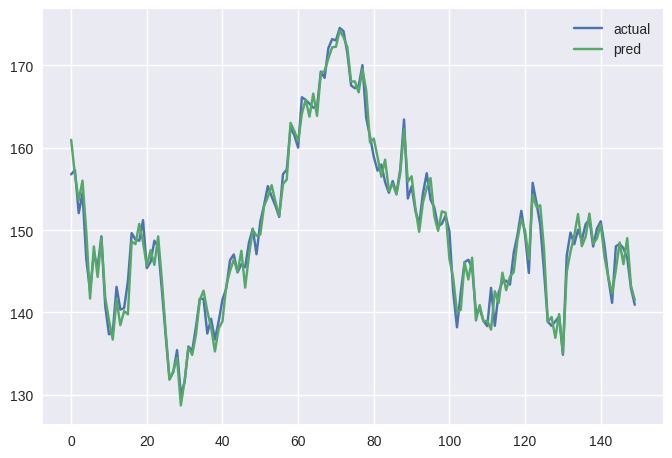

In [17]:
plt.plot(y_test, label="actual")
plt.plot(y_pred, label="pred")
plt.legend()
plt.show()

In [18]:
testScore = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 1.55 RMSE
